# Architecture experiment: Subjective and physiological responses to interiors


### Libraries

- [scikit-learn](http://scikit-learn.org/stable/)
- pandas
- matplotlib
- seaborn
- keras

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

In [111]:
DATA_FOLDER = './data/' #The data is in the .gitignore in order to not upload it to the GitHub repository

Execute the following line to export from the jupyter notebook(.ipynb) to a .py file (ignore the warnings):

In [112]:
#!jupyter nbconvert --to script Project2-Notebook.ipynb 

For not show the warnings:

In [113]:
import warnings
warnings.filterwarnings(action = 'once')

## Exploratory Data Analysis

### Loading phase

First we load the data into a Pandas data frame (with the Pandas library; to install this package with conda run:
`conda install -c anaconda pandas`):

In [114]:
df_interior_features = pd.read_csv(DATA_FOLDER + 'T_features.csv')
df_labels_and_features = pd.read_csv(DATA_FOLDER + 'table_dataset_GreeceSwitzerland_N265_metrics_mSC5_JPEGtoBMP_Michelson_RMS.csv')

Let's see what is inside `table_dataset_GreeceSwitzerland_N265_metrics_mSC5_JPEGtoBMP_Michelson_RMS.csv`:

In [115]:
df_labels_and_features.head(7)

,ID,Country,Stimulus_SkyType,Stimulus_Context,Gender,Pattern,pleasant,interesting,exciting,calming,complex,bright,view,spacious,contrast_mean_mSC5,contrast_mean_Michelson,contrast_mean_RMS,complexity_mean_JPEGtoBMP
0,1,Greece,clear low,social,Male,P1EL,8,7,6,9,4,6,4,8,11.188207,0.907864,106.363985,0.104734
1,1,Greece,clear low,social,Male,P2EL,8,5,6,8,4,7,3,8,11.941067,0.904661,106.590842,0.122357
2,1,Greece,clear low,social,Male,P3EL,9,8,8,9,6,7,2,8,12.509719,0.905066,106.604335,0.119979
3,1,Greece,clear low,social,Male,P4EL,7,7,7,7,6,6,1,8,12.846015,0.906583,106.929875,0.115287
4,1,Greece,clear low,social,Male,P5EL,8,10,9,7,8,7,5,8,12.211881,0.907546,105.478575,0.118572
5,1,Greece,clear low,social,Male,P6EL,8,8,8,7,9,7,3,8,12.288385,0.912304,106.582042,0.113396
6,2,Greece,clear low,social,Male,P1EL,6,7,8,6,0,7,6,7,11.188207,0.907864,106.363985,0.104734


In [116]:
df_labels_and_features.shape

(1590, 18)

In [117]:
df_labels_and_features.columns

Index(['ID', 'Country', 'Stimulus_SkyType', 'Stimulus_Context', 'Gender',
       'Pattern', 'pleasant', 'interesting', 'exciting', 'calming', 'complex',
       'bright', 'view', 'spacious', 'contrast_mean_mSC5',
       'contrast_mean_Michelson', 'contrast_mean_RMS',
       'complexity_mean_JPEGtoBMP'],
      dtype='object')

The data frame has 1590 rows × 18 columns where we can see the original sample of the experiment (both inputs and outputs (xn,yn)). Each column is explained below:
* 'ID': Identifier of the subject of the experiment (of one person).
* 'Country': Country where the person was living.  2 x countries (Greece –138 participants, Switzerland –127 participants)
* 'Stimulus_SkyType': 3 x sky types (clear sky with high sun angle, clear sky with low sun angle, overcast sky)
* 'Stimulus_Context':  2 x context scenarios (social scenario, work scenario)
* 'Gender': Male or Female
* 'Pattern': 6 x patterns (determine how are the blinds, and so how are the shadows)
* Outputs (yn): 'pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright', 'view', 'spacious'.
* interior metrics (for describing the interior (the kind of room, light, ...) quantitatively): 'contrast_mean_mSC5', 'contrast_mean_Michelson', 'contrast_mean_RMS', 'complexity_mean_JPEGtoBMP'.

Note: The metrics in this data set are applied to the whole virtual reallity image (in every interior).

Now let's see what is inside `T_features.csv`:

In [118]:
df_interior_features.head()

,filename,Pattern,Context,SkyType,mean_pleasant,median_pleasant,mean_interesting,median_interesting,mean_calming,median_calming,...,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP
0,p1_social_clearhigh_sg_largewin_simu,P1EL,social,clearhigh,5.439024,6,4.512195,4,5.731707,6.0,...,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797
1,p1_social_clearlow_sg_largewin_simu,P1EL,social,clearlow,5.571429,6,4.510204,5,5.897959,6.0,...,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709
2,p1_social_overcast_sg_largewin_simu,P1EL,social,overcast,6.093023,6,4.790698,5,6.651163,7.0,...,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091
3,p1_work_clearhigh_sg_largewin_simu,P1EL,work,clearhigh,5.804348,6,5.086957,5,6.152174,6.5,...,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,0.124465
4,p1_work_clearlow_sg_largewin_simu,P1EL,work,clearlow,5.255814,5,4.418605,5,5.837209,6.0,...,116,0.937813,0.887639,0.728223,108.174380,112.987399,126.132718,0.102264,0.139392,0.122615


In [119]:
df_interior_features.shape

(36, 31)

In [120]:
df_interior_features.columns

Index(['filename', 'Pattern', 'Context', 'SkyType', 'mean_pleasant',
       'median_pleasant', 'mean_interesting', 'median_interesting',
       'mean_calming', 'median_calming', 'mean_exciting', 'median_exciting',
       'mean_complex', 'median_complex', 'mean_bright', 'median_bright',
       'mean_view', 'median_view', 'mean_spacious', 'median_spacious',
       'contrast_mean_mSC5', 'contrast_max_mSC5', 'contrast_mean_Michelson',
       'contrast_mean_Michelson_cube123', 'contrast_mean_Michelson_cube3',
       'contrast_mean_RMS', 'contrast_mean_RMS_cube123',
       'contrast_mean_RMS_cube3', 'complexity_mean_JPEGtoBMP',
       'complexity_cube3_JPEGtoBMP', 'complexity_cube123_JPEGtoBMP'],
      dtype='object')

We have obtained a data frame with 36 rows × 31 columns. This time we see the features of each kind of interior (the kind of room, light, ...)  and several metrics for describing quantitatively the interior situation Each column is explained below:
* 'filename': File where we have the cube map projections associated to every interior. (See in `./Cubemap_Projections/BMP/<filename>` or `./Cubemap_Projections/JPEG/<filename>`). The filenames have the structure "p(pattern_id)_(context)_(SkyType)_sg_largewin_simu".
* 'Pattern': 6 x patterns (determine how are the blinds, and so how are the shadows)
* 'Context': 2 x context scenarios (social scenario, work scenario)
* 'SkyType': 3 x sky types (clear sky with high sun angle, clear sky with low sun angle, overcast sky)
* Means and medians of the outputs (of what people have answer in their respective survey): 'mean_pleasant', 'median_pleasant', 'mean_interesting', 'median_interesting', 'mean_calming', 'median_calming', mean_exciting', 'median_exciting', 'mean_complex', 'median_complex', 'mean_bright', 'median_bright', 'mean_view', 'median_view', 'mean_spacious', 'median_spacious',
* Interior metrics (for describing the interior quantitatively): 'contrast_mean_mSC5', 'contrast_max_mSC5', 'contrast_mean_Michelson', 'contrast_mean_Michelson_cube123', 'contrast_mean_Michelson_cube3', 'contrast_mean_RMS', 'contrast_mean_RMS_cube123','contrast_mean_RMS_cube3', 'complexity_mean_JPEGtoBMP', 'complexity_cube3_JPEGtoBMP', 'complexity_cube123_JPEGtoBMP'

Note: The metrics in this data set are applied not just to the whole virtual reallity image (we have already this data in the other data frame), but to the different parts of the whole image. Cube1 refers to what you see on your left (when you are doing the experiment with VR), cube2 refers to the front and cube3 refers to the right. Cube123 refers to the metric applied to the three subimages. For more details see`./Cubemap_Projections/JPEG/<filename>`.

Having done this previous load and brief analysis, we are going to create the data frame we are interested in work with. Firstly we find that our inputs (or features) could be classified in two types and we are taking both of them: 
* 1- Features of the people (country and gender) who have taken part in the experiment.
* 2- Features of the interior: Now we are taking both categorical and metrics data.

Secondly, the labels (outputs) of our new data frame are the data that comes from every survey (which has been done by each person): 'pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright', 'view', 'spacious'. We are asked to study first the 'exciting' and the 'calming' labels but we will split the data frame afterwards.

In [121]:
df_labels_and_features.sample()

,ID,Country,Stimulus_SkyType,Stimulus_Context,Gender,Pattern,pleasant,interesting,exciting,calming,complex,bright,view,spacious,contrast_mean_mSC5,contrast_mean_Michelson,contrast_mean_RMS,complexity_mean_JPEGtoBMP
190,32,Greece,overcast,work,Male,P5EL,3,3,3,3,5,3,2,6,6.309748,0.929996,105.055261,0.095358


In [122]:
#df_labels_and_features[df_labels_and_features['ID']==21] #What is the ID meaning?

In [123]:
df_interior_features.head(1)

,filename,Pattern,Context,SkyType,mean_pleasant,median_pleasant,mean_interesting,median_interesting,mean_calming,median_calming,...,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP
0,p1_social_clearhigh_sg_largewin_simu,P1EL,social,clearhigh,5.439024,6,4.512195,4,5.731707,6.0,...,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797


For doing the join, we check that one of the metrics determine totally the interior (there are not two interiors with the same metric value):

In [124]:
df_interior_features["to_join"]=(1000*df_interior_features["contrast_mean_RMS"]).astype(int) #We cannot do the join on the float
df_labels_and_features["to_join"]=(1000*df_labels_and_features["contrast_mean_RMS"]).astype(int) #so we add another column

df_interior_features.set_index("to_join").index.is_unique

True

In [125]:
df_labels_and_features.columns

Index(['ID', 'Country', 'Stimulus_SkyType', 'Stimulus_Context', 'Gender',
       'Pattern', 'pleasant', 'interesting', 'exciting', 'calming', 'complex',
       'bright', 'view', 'spacious', 'contrast_mean_mSC5',
       'contrast_mean_Michelson', 'contrast_mean_RMS',
       'complexity_mean_JPEGtoBMP', 'to_join'],
      dtype='object')

In [126]:
df_ml_raw = df_interior_features.merge(df_labels_and_features, on = "to_join", how = 'inner', suffixes = ("_a",""))
df_ml_raw.head(1)

,filename,Pattern_a,Context,SkyType,mean_pleasant,median_pleasant,mean_interesting,median_interesting,mean_calming,median_calming,...,exciting,calming,complex,bright,view,spacious,contrast_mean_mSC5,contrast_mean_Michelson,contrast_mean_RMS,complexity_mean_JPEGtoBMP
0,p1_social_clearhigh_sg_largewin_simu,P1EL,social,clearhigh,5.439024,6,4.512195,4,5.731707,6.0,...,5,7,0,7,6,9,5.023496,0.881714,104.887032,0.101518


In [127]:
df_ml_raw.columns

Index(['filename', 'Pattern_a', 'Context', 'SkyType', 'mean_pleasant',
       'median_pleasant', 'mean_interesting', 'median_interesting',
       'mean_calming', 'median_calming', 'mean_exciting', 'median_exciting',
       'mean_complex', 'median_complex', 'mean_bright', 'median_bright',
       'mean_view', 'median_view', 'mean_spacious', 'median_spacious',
       'contrast_mean_mSC5_a', 'contrast_max_mSC5',
       'contrast_mean_Michelson_a', 'contrast_mean_Michelson_cube123',
       'contrast_mean_Michelson_cube3', 'contrast_mean_RMS_a',
       'contrast_mean_RMS_cube123', 'contrast_mean_RMS_cube3',
       'complexity_mean_JPEGtoBMP_a', 'complexity_cube3_JPEGtoBMP',
       'complexity_cube123_JPEGtoBMP', 'to_join', 'ID', 'Country',
       'Stimulus_SkyType', 'Stimulus_Context', 'Gender', 'Pattern', 'pleasant',
       'interesting', 'exciting', 'calming', 'complex', 'bright', 'view',
       'spacious', 'contrast_mean_mSC5', 'contrast_mean_Michelson',
       'contrast_mean_RMS', 'compl

# New approach

Now we drop the duplicates columns and order the columns in order to have a data frame with the structure X|Y, where X is the matrix of features (each column is a feature) and Y is the matrix with the labels. 

In this new approach we are not using gender.

In [128]:
df_ml = df_ml_raw[['Country', 'Pattern', 'Context', 'SkyType', 'contrast_mean_mSC5', 'contrast_max_mSC5', 
               'contrast_mean_Michelson', 'contrast_mean_Michelson_cube123', 'contrast_mean_Michelson_cube3', 
               'contrast_mean_RMS', 'contrast_mean_RMS_cube123', 'contrast_mean_RMS_cube3', 'complexity_mean_JPEGtoBMP',
               'complexity_cube3_JPEGtoBMP', 'complexity_cube123_JPEGtoBMP', 'pleasant', 'interesting', 'exciting', 'calming', 
               'complex', 'bright', 'view', 'spacious']]

In [129]:
df_ml.head(1)

,Country,Pattern,Context,SkyType,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,...,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP,pleasant,interesting,exciting,calming,complex,bright,view,spacious
0,Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,...,0.158865,0.129797,7,5,5,7,0,7,6,9


We can also check and see that there are no missing values. (all instances are non-null)

In [130]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1590 entries, 0 to 1589
Data columns (total 23 columns):
Country                            1590 non-null object
Pattern                            1590 non-null object
Context                            1590 non-null object
SkyType                            1590 non-null object
contrast_mean_mSC5                 1590 non-null float64
contrast_max_mSC5                  1590 non-null int64
contrast_mean_Michelson            1590 non-null float64
contrast_mean_Michelson_cube123    1590 non-null float64
contrast_mean_Michelson_cube3      1590 non-null float64
contrast_mean_RMS                  1590 non-null float64
contrast_mean_RMS_cube123          1590 non-null float64
contrast_mean_RMS_cube3            1590 non-null float64
complexity_mean_JPEGtoBMP          1590 non-null float64
complexity_cube3_JPEGtoBMP         1590 non-null float64
complexity_cube123_JPEGtoBMP       1590 non-null float64
pleasant                           1590 non-

and see that all ratings are between 0 and 10:

In [131]:
df_ml[['pleasant', 'interesting', 'exciting', 'calming', 'complex', 'bright',
       'view', 'spacious']].describe().loc[['min','max']]


,pleasant,interesting,exciting,calming,complex,bright,view,spacious
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


Finally, to work with the new approach we need to compute the percentage of ratings  of every scene that are over a certain value (6, 7 or 8 for example). First we take a new data frame with just the 36 different scenes (72 if we are considering the country):

In [132]:
#x_fdata = df_ml.iloc[:,1:15] # For not considering the country
#x_fdata = df_ml.iloc[:,0:15] # For considering the country

fdata = df_ml.iloc[:,0:15] #fdata -> first data without preprocessing
fdata.drop_duplicates(inplace = True)
fdata.set_index(['Country', 'Pattern', 'Context', 'SkyType'], inplace = True)
fdata

,,,,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP
Country,Pattern,Context,SkyType,,,,,,,,,,,
Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797
Switzerland,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797
Greece,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709
Switzerland,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709
Greece,P1EL,social,overcast,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091
Switzerland,P1EL,social,overcast,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091
Greece,P1EL,work,clearhigh,5.362578,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,0.124465
Switzerland,P1EL,work,clearhigh,5.362578,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,0.124465
Greece,P1EL,work,clearlow,11.038933,116,0.937813,0.887639,0.728223,108.174380,112.987399,126.132718,0.102264,0.139392,0.122615


Now we compute the percentages which we are working in this new approach:

In [139]:
computing_percentages_df = df_ml[['Country', 'Pattern', 'Context', 'SkyType']].copy()


limit = 7 ## Change this variable for working with the percentage of people how felt more than limit-excited
df_ml_over_limit = df_ml[df_ml["exciting"] >= limit]
computing_percentages_df2 = df_ml_over_limit[['Country', 'Pattern', 'Context', 'SkyType']].copy()

In [140]:
computing_percentages_df["Total_people"] = 0
computing_percentages_df = computing_percentages_df.groupby(['Country', 'Pattern', 'Context', 'SkyType']).count()

In [141]:
computing_percentages_df2["Excited_people"] = 0
computing_percentages_df2 = computing_percentages_df2.groupby(['Country', 'Pattern', 'Context', 'SkyType']).count()

In [142]:
computing_percentages_joined = pd.DataFrame.join(computing_percentages_df, computing_percentages_df2).fillna(value=0)

In [143]:
fdata = fdata.join(computing_percentages_joined)

In [144]:
fdata[["Total_people", "Excited_people"]].head(3)

,,,,Total_people,Excited_people
Country,Pattern,Context,SkyType,,
Greece,P1EL,social,clearhigh,21,1.0
Switzerland,P1EL,social,clearhigh,20,0.0
Greece,P1EL,social,clearlow,27,5.0


In [145]:
fdata["Percentage_excited_people"] = fdata["Excited_people"] / fdata["Total_people"]

In [146]:
fdata.head()

,,,,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP,Total_people,Excited_people,Percentage_excited_people
Country,Pattern,Context,SkyType,,,,,,,,,,,,,,
Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797,21,1.0,0.047619
Switzerland,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797,20,0.0,0.000000
Greece,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709,27,5.0,0.185185
Switzerland,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709,22,2.0,0.090909
Greece,P1EL,social,overcast,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,0.113091,22,5.0,0.227273


In [147]:
fdata = fdata.drop(columns = ["Total_people", "Excited_people"])
fdata.reset_index(inplace = True)
fdata.head(3)

,Country,Pattern,Context,SkyType,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,complexity_cube123_JPEGtoBMP,Percentage_excited_people
0,Greece,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797,0.047619
1,Switzerland,P1EL,social,clearhigh,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,0.129797,0.000000
2,Greece,P1EL,social,clearlow,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,0.127709,0.185185


In [148]:
x_fdata = fdata.iloc[:, 0:15]
y_data = fdata["Percentage_excited_people"] #Note that y_data is a pandas Series

### Preprocesing Phase

From the dataframe we can see that there are 5 catgorical features:
1. __*Country*__  
2. __*Pattern*__ 
3. __*Context*__ 
4. __*SkyType*__ 

We can confirm this by checking the type of data for each feature:

In [149]:
x_fdata.dtypes

Country                             object
Pattern                             object
Context                             object
SkyType                             object
contrast_mean_mSC5                 float64
contrast_max_mSC5                    int64
contrast_mean_Michelson            float64
contrast_mean_Michelson_cube123    float64
contrast_mean_Michelson_cube3      float64
contrast_mean_RMS                  float64
contrast_mean_RMS_cube123          float64
contrast_mean_RMS_cube3            float64
complexity_mean_JPEGtoBMP          float64
complexity_cube3_JPEGtoBMP         float64
complexity_cube123_JPEGtoBMP       float64
dtype: object

As we can see the five features mentionned above are the only categorical features (type object).

Let's inspect these features closely:

In [150]:
categorical_features = ['Country','Pattern','Context', \
                        'SkyType']
for feat in categorical_features:
    print(feat + ':')
    print(x_fdata[feat].value_counts())

Country:
Switzerland    36
Greece         36
Name: Country, dtype: int64
Pattern:
P6EL    12
P4EL    12
P5EL    12
P2EL    12
P3EL    12
P1EL    12
Name: Pattern, dtype: int64
Context:
social    36
work      36
Name: Context, dtype: int64
SkyType:
clearlow     24
overcast     24
clearhigh    24
Name: SkyType, dtype: int64


In order to perform dummy variable encoding on the categorical features, we can use the pandas method `pd.get_dummies()`. Also since we need k-1 dummy variables to represent k categories, we can drop the first column for each encoding (`drop_first = True`). We'll store this as a new dataframe `dummy_df`.

In [151]:
dummy_df = pd.get_dummies(x_fdata, columns=categorical_features, drop_first=False)
dummy_df

,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,complexity_cube3_JPEGtoBMP,...,Pattern_P2EL,Pattern_P3EL,Pattern_P4EL,Pattern_P5EL,Pattern_P6EL,Context_social,Context_work,SkyType_clearhigh,SkyType_clearlow,SkyType_overcast
0,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,...,0,0,0,0,0,1,0,1,0,0
1,5.023496,82,0.881714,0.822095,0.696552,104.887032,116.926766,138.288359,0.101518,0.158865,...,0,0,0,0,0,1,0,1,0,0
2,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,...,0,0,0,0,0,1,0,0,1,0
3,11.188207,85,0.907864,0.846031,0.750000,106.363985,108.835770,119.479999,0.104734,0.136334,...,0,0,0,0,0,1,0,0,1,0
4,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,...,0,0,0,0,0,1,0,0,0,1
5,4.458815,49,0.886125,0.829098,0.713287,102.615246,113.078576,133.037937,0.093733,0.134794,...,0,0,0,0,0,1,0,0,0,1
6,5.362578,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,...,0,0,0,0,0,0,1,1,0,0
7,5.362578,116,0.924177,0.874757,0.680272,107.051167,119.883534,142.784796,0.099205,0.159858,...,0,0,0,0,0,0,1,1,0,0
8,11.038933,116,0.937813,0.887639,0.728223,108.174380,112.987399,126.132718,0.102264,0.139392,...,0,0,0,0,0,0,1,0,1,0
9,11.038933,116,0.937813,0.887639,0.728223,108.174380,112.987399,126.132718,0.102264,0.139392,...,0,0,0,0,0,0,1,0,1,0


We standardize the features in preparation for the training (output excluded, "exciting" column).

In [152]:
x_without_std = dummy_df.copy() #x_without_std is the final data without standardize (Just in case you want to use it)

for feat in dummy_df.columns.tolist():
    mean = dummy_df[feat].mean()
    std = dummy_df[feat].std()
    dummy_df[feat] = (dummy_df[feat] - mean)/std

In [153]:
x_data = dummy_df #x_data will be the final standardized data

#### Splitting the data

In order to split the data into the two sets (training and test), first we need to rejoin the y_data and the x_data. Then we can use the sample method (`pd.sample()`) which  randomly samples from the dataframe according to a given ratio (0.8 for train in this case). The remaining part of the data will be the test set.

In [56]:
#In order to split the data, we join then again:
data = pd.concat([y_data, x_data], axis=1, sort=False)
data.head(1)

,Percentage_excited_people,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,...,Pattern_P2EL,Pattern_P3EL,Pattern_P4EL,Pattern_P5EL,Pattern_P6EL,Context_social,Context_work,SkyType_clearhigh,SkyType_clearlow,SkyType_overcast
0,0.047619,-0.950306,-0.992096,-1.462638,-1.458138,-1.179713,-0.454993,0.636979,0.703101,-0.1363,...,-0.444097,-0.444097,-0.444097,-0.444097,-0.444097,0.993031,-0.993031,1.404358,-0.702179,-0.702179


In [57]:
train_df = data.sample(frac=0.8,replace=False)
test_df = data.drop(train_df.index.tolist(),axis=0)

In [58]:
train_df.head(3)

,Percentage_excited_people,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,...,Pattern_P2EL,Pattern_P3EL,Pattern_P4EL,Pattern_P5EL,Pattern_P6EL,Context_social,Context_work,SkyType_clearhigh,SkyType_clearlow,SkyType_overcast
43,0.260870,-0.272251,0.771630,0.714451,0.812810,-0.951205,0.670655,1.435221,1.093408,-0.208998,...,-0.444097,-0.444097,2.220485,-0.444097,-0.444097,-0.993031,0.993031,1.404358,-0.702179,-0.702179
9,0.000000,1.025769,0.881863,1.191152,1.020812,0.227417,1.410156,-0.555571,-0.897602,-0.055774,...,-0.444097,-0.444097,-0.444097,-0.444097,-0.444097,-0.993031,0.993031,-0.702179,1.404358,-0.702179
40,0.363636,-0.687125,-0.826747,-1.132126,-0.964583,0.412748,-1.654766,-0.444368,-0.042804,-0.857902,...,-0.444097,-0.444097,2.220485,-0.444097,-0.444097,0.993031,-0.993031,-0.702179,-0.702179,1.404358


In [59]:
test_df.head(3)

,Percentage_excited_people,contrast_mean_mSC5,contrast_max_mSC5,contrast_mean_Michelson,contrast_mean_Michelson_cube123,contrast_mean_Michelson_cube3,contrast_mean_RMS,contrast_mean_RMS_cube123,contrast_mean_RMS_cube3,complexity_mean_JPEGtoBMP,...,Pattern_P2EL,Pattern_P3EL,Pattern_P4EL,Pattern_P5EL,Pattern_P6EL,Context_social,Context_work,SkyType_clearhigh,SkyType_clearlow,SkyType_overcast
7,0.130435,-0.838917,0.881863,0.546094,0.533617,-1.903004,0.772877,1.532070,1.295210,-0.386231,...,-0.444097,-0.444097,-0.444097,-0.444097,-0.444097,-0.993031,0.993031,1.404358,-0.702179,-0.702179
12,0.047619,-1.032270,-1.047213,-1.462549,-1.475606,-1.486122,-0.533784,0.645462,0.712380,-0.112839,...,2.220485,-0.444097,-0.444097,-0.444097,-0.444097,0.993031,-0.993031,1.404358,-0.702179,-0.702179
25,0.150000,-0.698221,0.055116,-1.280122,-1.183901,-0.566896,-0.519684,0.583160,0.566577,-0.230737,...,-0.444097,2.220485,-0.444097,-0.444097,-0.444097,0.993031,-0.993031,1.404358,-0.702179,-0.702179


Quick check of the validity of the split by making sure that the size of the train plus the size of the test equals the size of the dummy:

In [60]:
print(train_df.shape[0] + test_df.shape[0] == dummy_df.shape[0])

True


Hence our standardized features and our labels are ready to go.

In [61]:
x_train = train_df.iloc[:,1:-1]
y_train = train_df.iloc[:,0:1]
x_test = test_df.iloc[:,1:-1]
y_test = test_df.iloc[:, 0:1]
#x_data and y_data are the preprocessed data without splitting. Maybe we can use them considering that we have very few data

In [62]:
print(y_train.head)

<bound method NDFrame.head of     Percentage_excited_people
43                   0.260870
9                    0.000000
40                   0.363636
64                   0.454545
53                   0.285714
2                    0.185185
17                   0.285714
10                   0.136364
45                   0.250000
47                   0.190476
21                   0.000000
71                   0.333333
14                   0.185185
52                   0.500000
18                   0.260870
22                   0.136364
70                   0.318182
16                   0.227273
5                    0.047619
57                   0.400000
61                   0.350000
58                   0.318182
51                   0.454545
63                   0.545455
26                   0.370370
30                   0.391304
3                    0.090909
32                   0.521739
39                   0.545455
4                    0.227273
15                   0.227273
23        

In [63]:
print(x_train.head)

<bound method NDFrame.head of     contrast_mean_mSC5  contrast_max_mSC5  contrast_mean_Michelson  \
43           -0.272251           0.771630                 0.714451   
9             1.025769           0.881863                 1.191152   
40           -0.687125          -0.826747                -1.132126   
64           -0.598834           0.881863                -0.928654   
53           -0.688702           0.275582                -1.112881   
2             1.074806          -0.826747                -0.225601   
17           -1.163086          -2.700706                -1.274227   
10           -0.985375          -0.110233                 0.634895   
45            1.502723           0.936980                 1.261332   
47           -0.522262          -0.055116                 0.775101   
21            1.190925           0.661397                 1.140571   
71           -0.429425           0.881863                 0.863138   
14            1.322121          -1.102329                -0.

### Visualisation 

#### Correlations

In [154]:
x_data.columns

Index(['contrast_mean_mSC5', 'contrast_max_mSC5', 'contrast_mean_Michelson',
       'contrast_mean_Michelson_cube123', 'contrast_mean_Michelson_cube3',
       'contrast_mean_RMS', 'contrast_mean_RMS_cube123',
       'contrast_mean_RMS_cube3', 'complexity_mean_JPEGtoBMP',
       'complexity_cube3_JPEGtoBMP', 'complexity_cube123_JPEGtoBMP',
       'Country_Greece', 'Country_Switzerland', 'Pattern_P1EL', 'Pattern_P2EL',
       'Pattern_P3EL', 'Pattern_P4EL', 'Pattern_P5EL', 'Pattern_P6EL',
       'Context_social', 'Context_work', 'SkyType_clearhigh',
       'SkyType_clearlow', 'SkyType_overcast'],
      dtype='object')

In [155]:
numeric_data = pd.concat([y_data, x_data], axis=1, sort=False).drop( [ 'Country_Greece', 'Country_Switzerland', 'Pattern_P1EL', 'Pattern_P2EL',
       'Pattern_P3EL', 'Pattern_P4EL', 'Pattern_P5EL', 'Pattern_P6EL',
       'Context_social', 'Context_work', 'SkyType_clearhigh',
       'SkyType_clearlow', 'SkyType_overcast'], axis = 1)



numeric_data.corr()["Percentage_excited_people"]

Percentage_excited_people          1.000000
contrast_mean_mSC5                 0.283798
contrast_max_mSC5                  0.277502
contrast_mean_Michelson            0.012671
contrast_mean_Michelson_cube123    0.023316
contrast_mean_Michelson_cube3      0.485342
contrast_mean_RMS                 -0.008764
contrast_mean_RMS_cube123         -0.215576
contrast_mean_RMS_cube3           -0.230176
complexity_mean_JPEGtoBMP          0.221907
complexity_cube3_JPEGtoBMP         0.210864
complexity_cube123_JPEGtoBMP       0.242248
Name: Percentage_excited_people, dtype: float64

#### plots

We visualize the relations between "exciting"(response variable) and the features

C:\Users\kiyarash\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


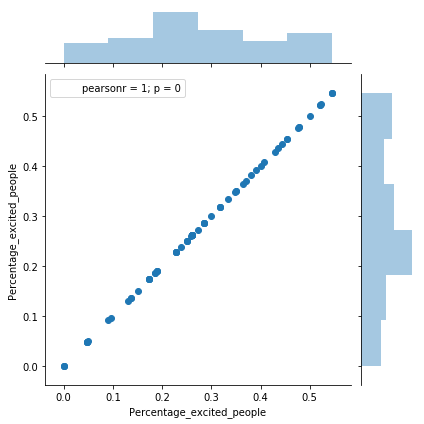

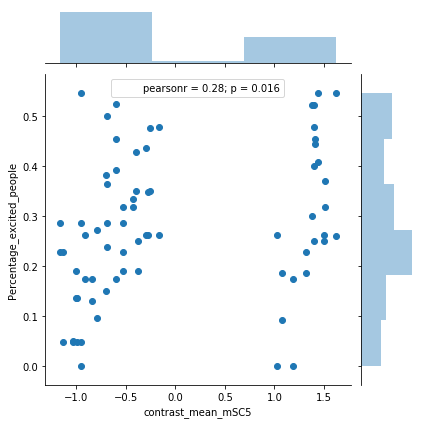

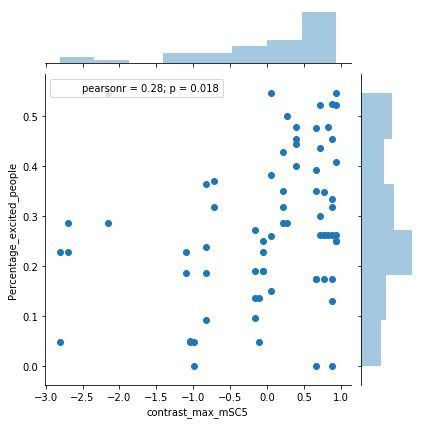

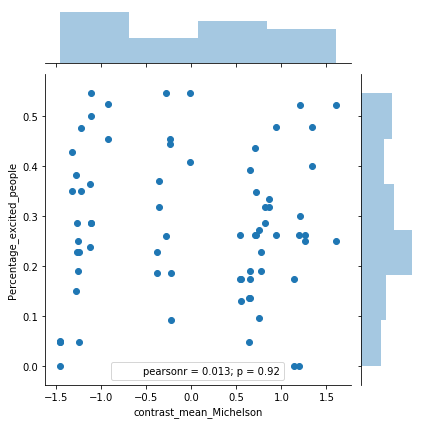

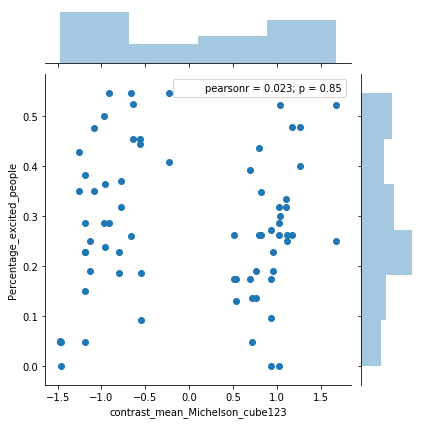

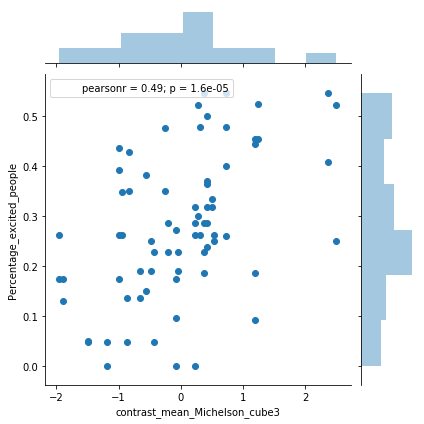

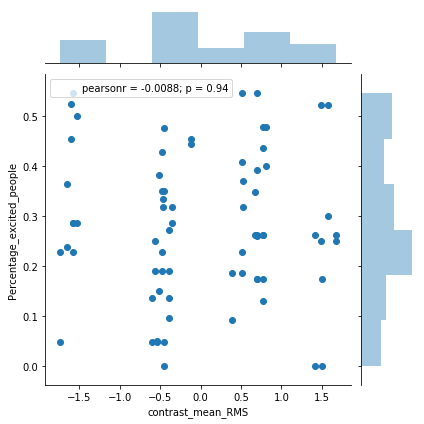

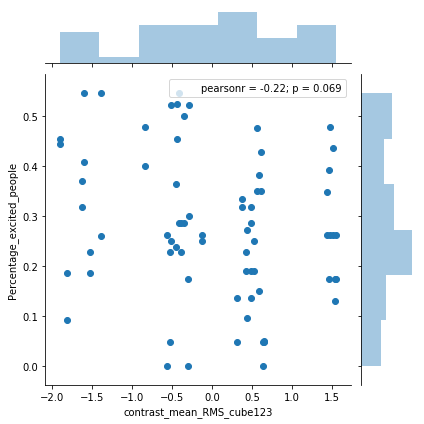

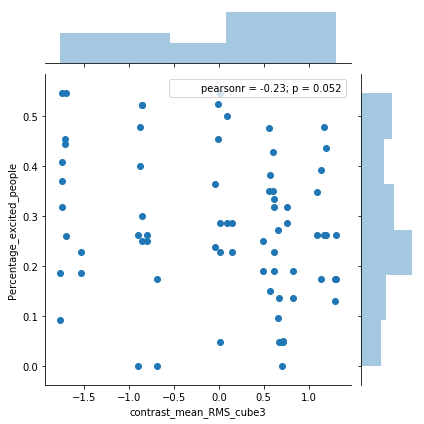

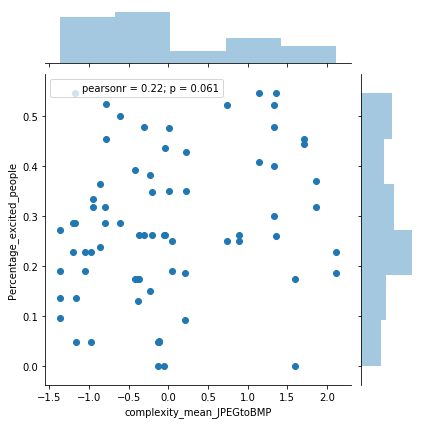

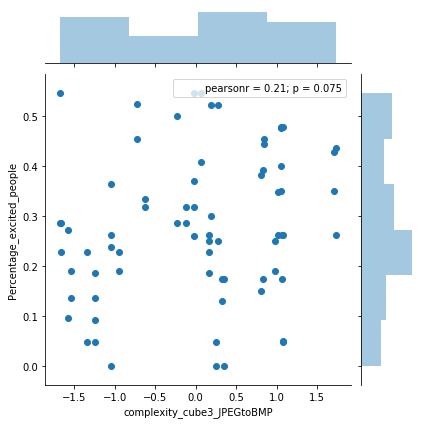

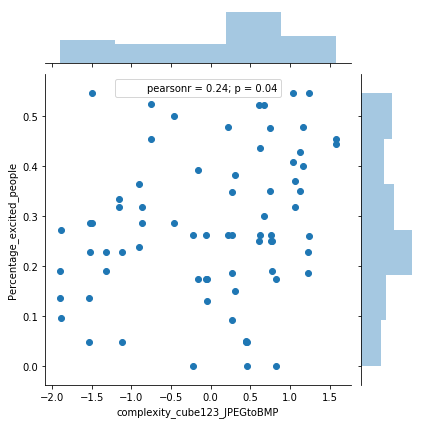

In [72]:
for feature in numeric_data.columns:
    sns.jointplot( numeric_data[feature], numeric_data['Percentage_excited_people'], kind ="scatter")

we can also demonstrate the linear regression line estimate for each feature.

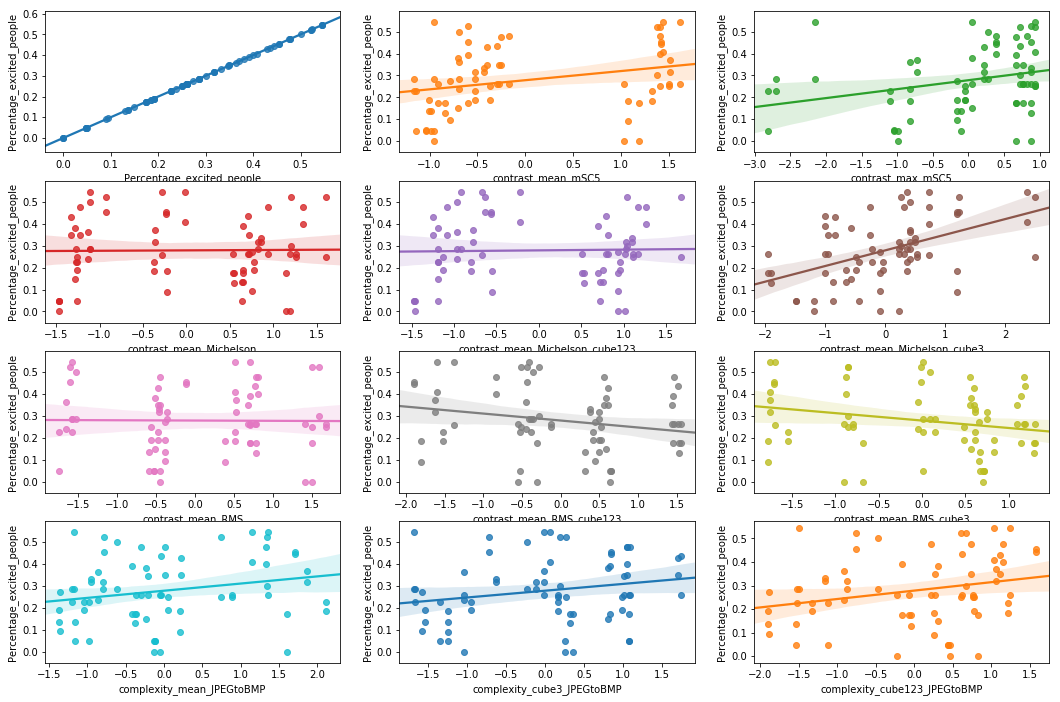

In [156]:
fig, ax = plt.subplots(round(len(numeric_data.columns) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
        sns.regplot(x=numeric_data.columns[i],y='Percentage_excited_people', data=numeric_data, ax=ax)

## Exploring different approachs

Having done that, we can start trying differents methods for obtaining predictions about the excitation/calm of a person who do the experiment.

In [76]:
#!jupyter nbconvert --to script Project2-Notebook - New Approach.ipynb 

In [214]:
#y_train = y_train.transpose()
print(x_train.shape[0], x_train.shape[1])
print(y_train.shape[0], y_train.shape[1])

print(x_test.shape[0], x_test.shape[1])
print(y_test.shape[0], y_test.shape[1])

(58, 19)
(58, 1)
(14, 19)
(14, 1)


## RIDGE REGRESSION 

In [204]:
# First try

In [251]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
clf = Ridge(alpha=1.0)
clf.fit(x_train, y_train)

y_pred=clf.predict(x_train)

In [218]:
#print(y_pred)

In [219]:
#print(y_train) ## I think the results of the model over the trained data seems to be not very bad

In [ ]:
import matplotlib.pyplot as plt

In [298]:
# Hard Try

In [321]:
lambdas = np.concatenate((np.array([0]), np.logspace(-9, 10, 22)), axis=0)
degrees = np.array([1, 2, 3, 4, 5])
ypred_train=np.zeros((len(y_train), len(lambdas), len(degrees)))
ypred_test=np.zeros((len(y_test), len(lambdas), len(degrees)))

xtrain=x_train.values
ytrain=y_train.values

xtest=x_test.values
ytest=y_test.values

h=0
w=0
while(w<len(degrees)):
    pol = PolynomialFeatures(degrees[w], True, True)
    phx_train = pol.fit_transform(xtrain, ytrain)
    phx_test = pol.fit_transform(xtest, ytest)
    h=0
    while(h<len(lambdas)):
        clf = Ridge(lambdas[h], solver="lsqr")
        clf.fit(phx_train, y_train)
        ypred_train[:,h,w]=clf.predict(phx_train).transpose()
        ypred_test[:,h,w]=clf.predict(phx_test).transpose()
        h=h+1
    w=w+1

#We can play with the function: PolynomialFeatures

In [322]:
#plt.title("MSE Y pred train vs Lambdas")
#plt.xlabel("Lambdas")
#plt.semilogx(lambdas, mse_pred_test[0])


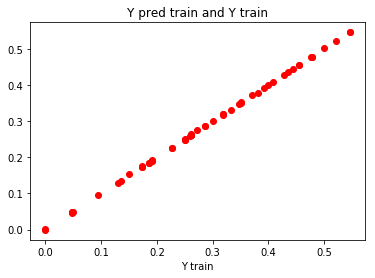

In [324]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_train, ypred_train[:,0,4], 'ro')
#We can see that the shape of the graphic tends to be a linear (everything matches). Seems to OVERFITTING
#Here we are taking degree 5 and small lambda

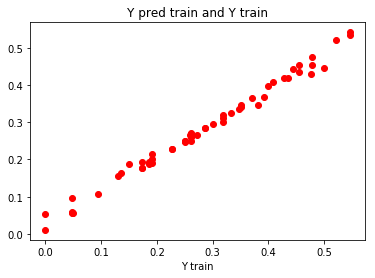

In [332]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_train, ypred_train[:,14,4], 'ro') # Lambda starts to affect, higher values of lambda 

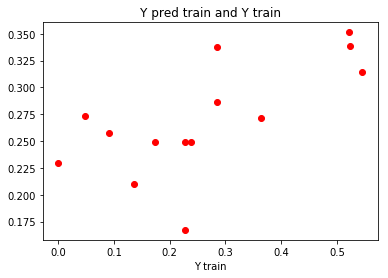

In [316]:
#For the test
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_test, ypred_test[:,16, 4], 'ro') 
# As we see we are overfitting, lets plot with less degree

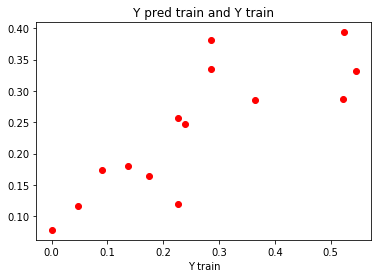

In [317]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_test, ypred_test[:,16, 0], 'ro') #Seems to try to be linear

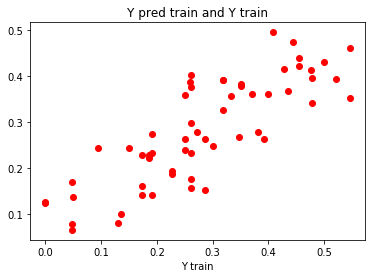

In [336]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_train, ypred_train[:,10, 0], 'ro') #Seems to try to be linear

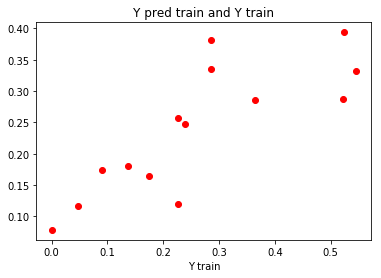

In [318]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_test, ypred_test[:,0, 0], 'ro') #Seems to try to be linear

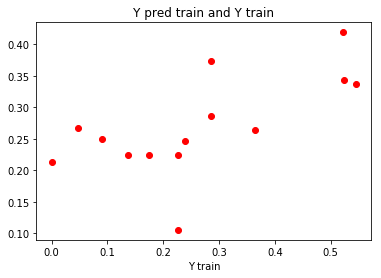

In [319]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_test, ypred_test[:,10, 3], 'ro')

In [247]:
print(ypred_train[:,10])

[0.3713948  0.22997328 0.13834357 0.38343541 0.15259591 0.23192716
 0.22107094 0.09163659 0.37602723 0.11481448 0.30699922 0.16609383
 0.33361647 0.3616577  0.1159417  0.19219494 0.24357398 0.39970295
 0.10056524 0.37531868 0.41380557 0.15372003 0.23040702 0.44712104
 0.37493069 0.28783165 0.20579565 0.36600831 0.1283155  0.2697055
 0.45008749 0.28245535 0.36192461 0.48489937 0.50717131 0.18805957
 0.33754035 0.20679554 0.32023368 0.24891103 0.42121374 0.24896577
 0.46939298 0.20065908 0.05385825 0.32012625 0.15028123 0.21113269
 0.28674411 0.36857    0.35790458 0.25005332 0.39943603 0.40378665
 0.42204373 0.07746161 0.40634833 0.1690172 ]


In [248]:
ypred_train[:,0]

array([0.37138875, 0.2299773 , 0.13833801, 0.38343894, 0.15259876,
       0.23192623, 0.22107117, 0.09163721, 0.37602778, 0.1148175 ,
       0.30700517, 0.1660924 , 0.33361009, 0.36165423, 0.11594328,
       0.19219864, 0.24356978, 0.39970883, 0.10055935, 0.37531694,
       0.41380644, 0.15372194, 0.2304011 , 0.44712124, 0.37493085,
       0.28783658, 0.20579112, 0.3660091 , 0.12831374, 0.26970489,
       0.45009207, 0.28245976, 0.36193017, 0.4848999 , 0.50717096,
       0.18805789, 0.33753828, 0.20679957, 0.32023842, 0.24890636,
       0.42121761, 0.24896518, 0.4693923 , 0.20065135, 0.05385855,
       0.32012612, 0.15027923, 0.2111277 , 0.28674384, 0.36856846,
       0.35790478, 0.25005792, 0.3994329 , 0.40378776, 0.42204494,
       0.07746144, 0.40634712, 0.16902091])

In [249]:
ypred_train[:,16]

array([0.37250258, 0.22924415, 0.13935525, 0.38278381, 0.15207897,
       0.23209471, 0.22103824, 0.09152949, 0.37593309, 0.11425167,
       0.3058927 , 0.16635838, 0.33478463, 0.36229456, 0.11566079,
       0.1915262 , 0.24434627, 0.3986243 , 0.1016373 , 0.3756469 ,
       0.41365103, 0.15337874, 0.2314804 , 0.44708265, 0.37491386,
       0.28693483, 0.20662833, 0.3658608 , 0.12864044, 0.26981266,
       0.44923577, 0.28164871, 0.36090636, 0.48480059, 0.50722854,
       0.18836449, 0.33792896, 0.20605016, 0.31936666, 0.24976543,
       0.42050175, 0.24907161, 0.4695106 , 0.20206304, 0.05381154,
       0.3201548 , 0.15064654, 0.21204749, 0.28678956, 0.36884463,
       0.35787274, 0.24921688, 0.4000125 , 0.40357875, 0.42182948,
       0.07748878, 0.40656257, 0.16833221])

In [ ]:
plt.title("Y pred train and Y train")
plt.xlabel("Y train")
plt.plot(y_train, ypred_train[:,0], 'ro')

### Using pipelines to make things cleaner

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

estimators = [('poly', PolynomialFeatures()), ('rig_reg', Ridge(solver="lsqr"))]
pipe = Pipeline(estimators)
pipe 

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('rig_reg', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='lsqr', tol=0.001))])

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

lambdas = np.concatenate((np.array([0]), np.logspace(-9, 10, 22)), axis=0)
degrees = np.array([1, 2, 3])

param_grid = dict(poly__degree = degrees,
                  rig_reg__alpha = lambdas)
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=0)

In [108]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('rig_reg', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='lsqr', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'poly__degree': array([1, 2, 3]), 'rig_reg__alpha': array([0.00000e+00, 1.00000e-09, 8.03086e-09, 6.44947e-08, 5.17947e-07,
       4.15956e-06, 3.34048e-05, 2.68270e-04, 2.15443e-03, 1.73020e-02,
       1.38950e-01, 1.11588e+00, 8.96151e+00, 7.19686e+01, 5.77969e+02,
       4.64159e+03, 3.72759e+04, 2.99358e+05, 2.40410e+06, 1.93070e+07,
       1.55052e+08, 1.24520e+09, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [109]:
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()



Best parameters set found on development set:

{'poly__degree': 3, 'rig_reg__alpha': 577.9692884153325}

Grid scores on development set:

-0.106 (+/-0.031) for {'poly__degree': 1, 'rig_reg__alpha': 0.0}
-0.106 (+/-0.031) for {'poly__degree': 1, 'rig_reg__alpha': 1e-09}
-0.106 (+/-0.031) for {'poly__degree': 1, 'rig_reg__alpha': 8.030857221391521e-09}
-0.106 (+/-0.031) for {'poly__degree': 1, 'rig_reg__alpha': 6.44946677103762e-08}
-0.106 (+/-0.031) for {'poly__degree': 1, 'rig_reg__alpha': 5.179474679231213e-07}
-0.106 (+/-0.031) for {'poly__degree': 1, 'rig_reg__alpha': 4.159562163071843e-06}
-0.106 (+/-0.031) for {'poly__degree': 1, 'rig_reg__alpha': 3.340484983513244e-05}
-0.106 (+/-0.030) for {'poly__degree': 1, 'rig_reg__alpha': 0.0002682695795279727}
-0.105 (+/-0.030) for {'poly__degree': 1, 'rig_reg__alpha': 0.002154434690031882}
-0.104 (+/-0.026) for {'poly__degree': 1, 'rig_reg__alpha': 0.017301957388458945}
-0.102 (+/-0.023) for {'poly__degree': 1, 'rig_reg__alpha': 0.1389495

## Performing PCA on images

First we read the images and load them into an array.

To install imageio use the command "conda install -c conda-forge imageio"

In [220]:
import imageio

path= r'C:\Users\kiyarash\Desktop\bmp_images\BMP\p1_social_clearhigh_sg_largewin_simu\cube_persp.bmp'
im = imageio.imread(paths)

print(im.shape)

OSError: Cannot understand given URI: ['./data/BMP/p1_social_clearhigh_sg_largewin_simu/cube_pe....

In [215]:

im = np.asarray(im)

In [216]:
im.shape

(1368, 4104, 3)

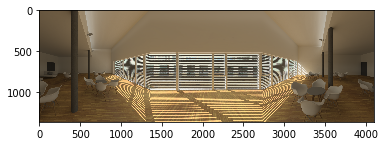

In [217]:
plt.imshow(im)

In [218]:
#flatten image for use

im = im.flatten()
im.shape

(16842816,)

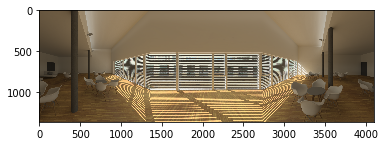

In [219]:
# this way we can reproduce the image
im = im.reshape([1368, 4104, 3])
plt.imshow(im)

In [290]:
# read all the images
shadows = ['p1', 'p2', 'p3','p4', 'p5', 'p6']
enviro = ['social', 'work']
sun = ['clearhigh', 'clearlow', 'overcast']

Image_path = DATA_FOLDER +"BMP/"
image_name = "cube_persp.bmp"

pixels = []

for sh in shadows:
    for e in enviro:
        for s in sun:
            folder_name = sh+ "_"+ e+ "_"+ s+ "_"+ "sg_largewin_simu/"
            path = Image_path+ folder_name + image_name 
            im = imageio.imread(path)
            im = np.asarray(im)
            im = im.flatten()
            pixels.append([sh.upper()+"EL", e, s, im])
            

In [291]:
pixels_df = pd.DataFrame(pixels)

In [298]:
pixels_df.columns = ['Pattern', 'Context', 'SkyType', 'img_array']

In [299]:
pixels_df.sample(4)

,Pattern,Context,SkyType,img_array
15,P3EL,work,clearhigh,"[107, 91, 66, 107, 91, 66, 107, 91, 66, 107, 9..."
34,P6EL,work,clearlow,"[112, 92, 66, 112, 92, 66, 112, 92, 66, 112, 9..."
11,P2EL,work,overcast,"[97, 85, 63, 97, 85, 63, 97, 85, 63, 97, 85, 6..."
10,P2EL,work,clearlow,"[110, 92, 66, 110, 92, 66, 110, 92, 67, 110, 9..."


In [300]:
fdata[['Country', 'Pattern', 'Context', 'SkyType', 'Percentage_excited_people']].sample(3)

,Country,Pattern,Context,SkyType,Percentage_excited_people
61,Switzerland,P6EL,social,clearhigh,0.350000
0,Greece,P1EL,social,clearhigh,0.047619
60,Greece,P6EL,social,clearhigh,0.476190


In [301]:
percent_excited = fdata[['Country', 'Pattern', 'Context', 'SkyType', 'Percentage_excited_people']]

In [303]:
pixels_excited_df = percent_excited.set_index(['Pattern', 'Context', 'SkyType']).join(pixels_df.set_index(['Pattern', 'Context', 'SkyType']))

In [304]:
pixels_excited_df

Country  Percentage_excited_people  \
Pattern Context SkyType                                             
P1EL    social  clearhigh       Greece                   0.047619   
                clearhigh  Switzerland                   0.000000   
                clearlow        Greece                   0.185185   
                clearlow   Switzerland                   0.090909   
                overcast        Greece                   0.227273   
                overcast   Switzerland                   0.047619   
        work    clearhigh       Greece                   0.173913   
                clearhigh  Switzerland                   0.130435   
                clearlow        Greece                   0.260870   
                clearlow   Switzerland                   0.000000   
                overcast        Greece                   0.136364   
                overcast   Switzerland                   0.047619   
P2EL    social  clearhigh       Greece                   0.047619   
                clearhigh  Switzerland                   0.050000   
                clearlow        Greece                   0.185185   
                clearlow   Switzerland                   0.227273   
                overcast        Greece                   0.227273   
                overcast   Switzerland                   0.285714   
        work    clearhigh       Greece                   0.260870   
                clearhigh  Switzerland                   0.173913   
                clearlow        Greece                   0.173913   
                clearlow   Switzerland                   0.000000   
                overcast        Greece                   0.136364   
                overcast   Switzerland                   0.190476   
P3EL    social  clearhigh       Greece                   0.380952   
                clearhigh  Switzerland                   0.150000   
                clearlow        Greece                   0.370370   
                clearlow   Switzerland                   0.318182   
                overcast        Greece                   0.545455   
                overcast   Switzerland                   0.285714   
...                                ...                        ...   
P4EL    work    clearhigh       Greece                   0.347826   
                clearhigh  Switzerland                   0.260870   
                clearlow        Greece                   0.260870   
                clearlow   Switzerland                   0.250000   
                overcast        Greece                   0.227273   
                overcast   Switzerland                   0.190476   
P5EL    social  clearhigh       Greece                   0.428571   
                clearhigh  Switzerland                   0.350000   
                clearlow        Greece                   0.444444   
                clearlow   Switzerland                   0.454545   
                overcast        Greece                   0.500000   
                overcast   Switzerland                   0.285714   
        work    clearhigh       Greece                   0.260870   
                clearhigh  Switzerland                   0.434783   
                clearlow        Greece                   0.478261   
                clearlow   Switzerland                   0.400000   
                overcast        Greece                   0.318182   
                overcast   Switzerland                   0.285714   
P6EL    social  clearhigh       Greece                   0.476190   
                clearhigh  Switzerland                   0.350000   
                clearlow        Greece                   0.407407   
                clearlow   Switzerland                   0.545455   
                overcast        Greece                   0.454545   
                overcast   Switzerland                   0.523810   
        work    clearhigh       Greece                   0.260870   
                clearhigh  Sw